In [7]:
from experiments.mlp import MLPExperiment
from layers.hebbian_layer import HebbianLayer
from models.hebbian_network import HebbianNetwork
import torch
import os
import matplotlib.pyplot as plt
import math
import numpy as np

In [32]:
experiment=MLPExperiment(None, 784, 64 , 10, lamb=15, num_epochs=3, heb_lr=0.005, eps=0.01)
experiment.train()
experiment.visualizeWeights()

0.6115


In [8]:
accuracies=[]
active=[]
l_array=range(1,16)
for l in l_array:
    experiment=MLPExperiment(None, 784, 64 , 10, lamb=l, num_epochs=3, heb_lr=0.005, eps=0.01)
    experiment.train()
    accuracies.append(experiment.test())
    
    

In [10]:
print(accuracies)

[0.6994, 0.6438, 0.5739, 0.6273, 0.6564, 0.4874, 0.5506, 0.5802, 0.552, 0.627, 0.6338, 0.5947, 0.5837, 0.6219, 0.6282]


Text(0.5, 1.0, 'Model Accuracy vs Lambda Value')

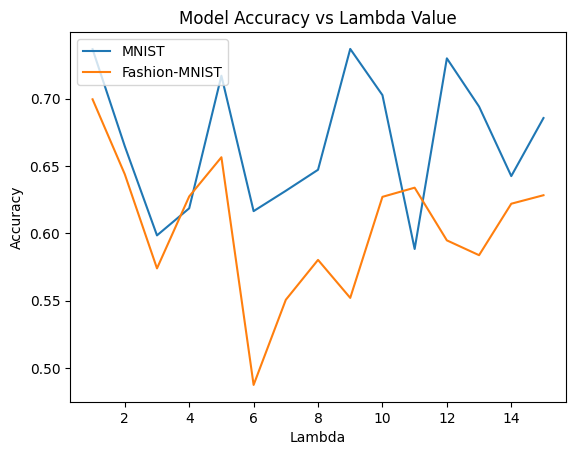

In [11]:
plt.plot(range(1,16), [0.7366, 0.6646, 0.5984, 0.6185, 0.7169, 0.6164, 0.6315, 0.6471, 0.7368, 0.7025, 0.5883, 0.7298, 0.694, 0.6424, 0.6855], label="MNIST")
plt.plot(range(1,16), accuracies, label="Fashion-MNIST")
plt.plot()
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.legend(loc='bottom ')
plt.title("Model Accuracy vs Lambda Value")

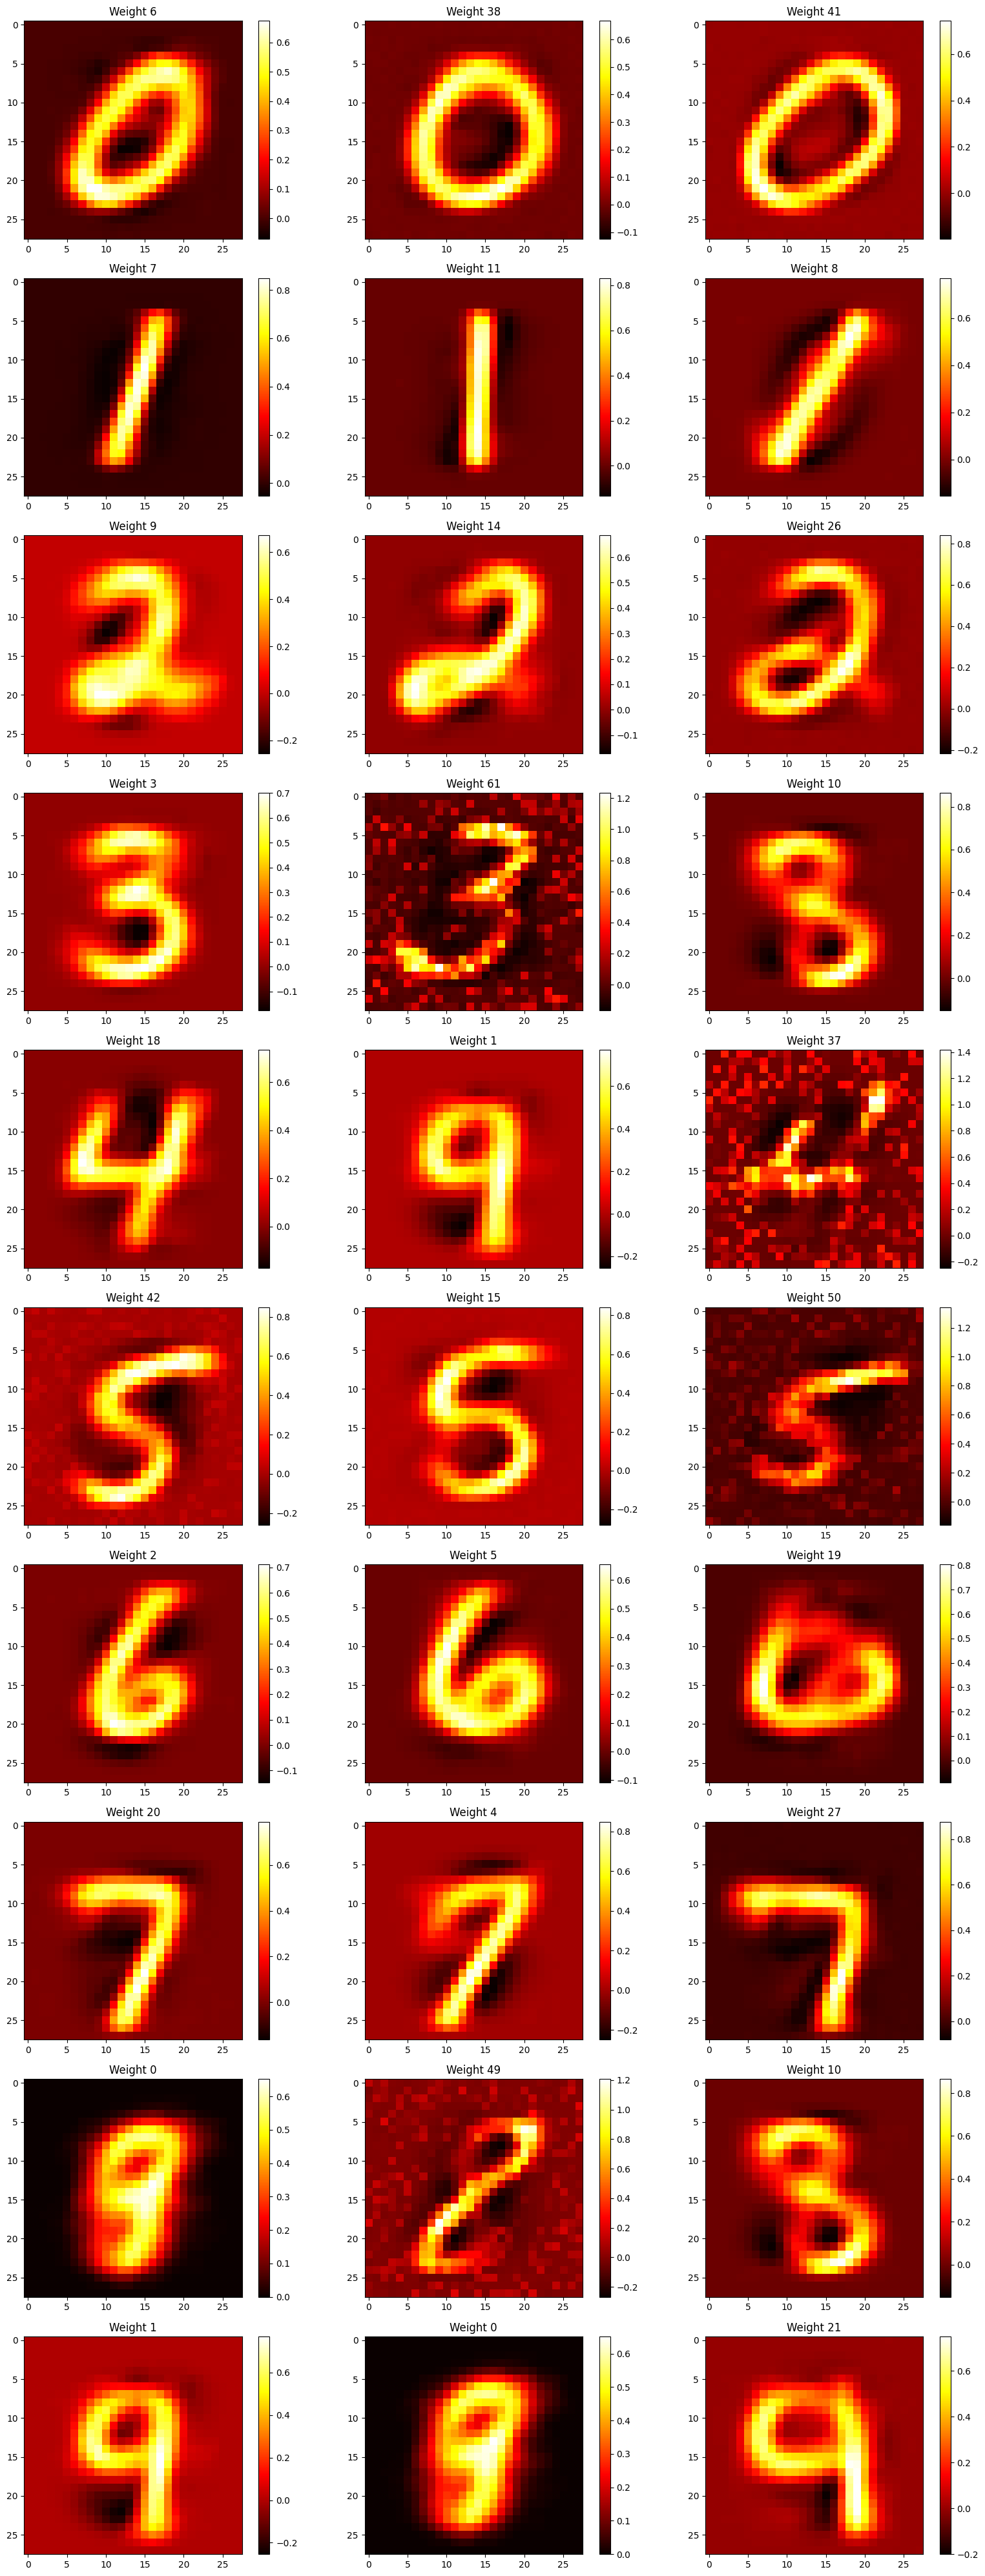

In [3]:
model_classifier_weight=experiment.model.classifier_layer.fc.weight
model_feature_selectors=experiment.model.hebbian_layer.fc.weight

fig, axes = plt.subplots(10, 3, figsize=(16, 40))

for i in range(10):
    top_3 = torch.topk(model_classifier_weight[i], 3).indices
    for j in range(3):
        ele = top_3[j]
        feature_selector = model_feature_selectors[ele]  # This line might need correction
        heatmap = feature_selector.view(int(math.sqrt(feature_selector.size(0))), int(math.sqrt(feature_selector.size(0))))
        ax = axes[i, j]
        im = ax.imshow(heatmap, cmap='hot', interpolation='nearest')
        fig.colorbar(im, ax=ax)
        ax.set_title(f'Weight {ele}')

plt.tight_layout()
plt.show()

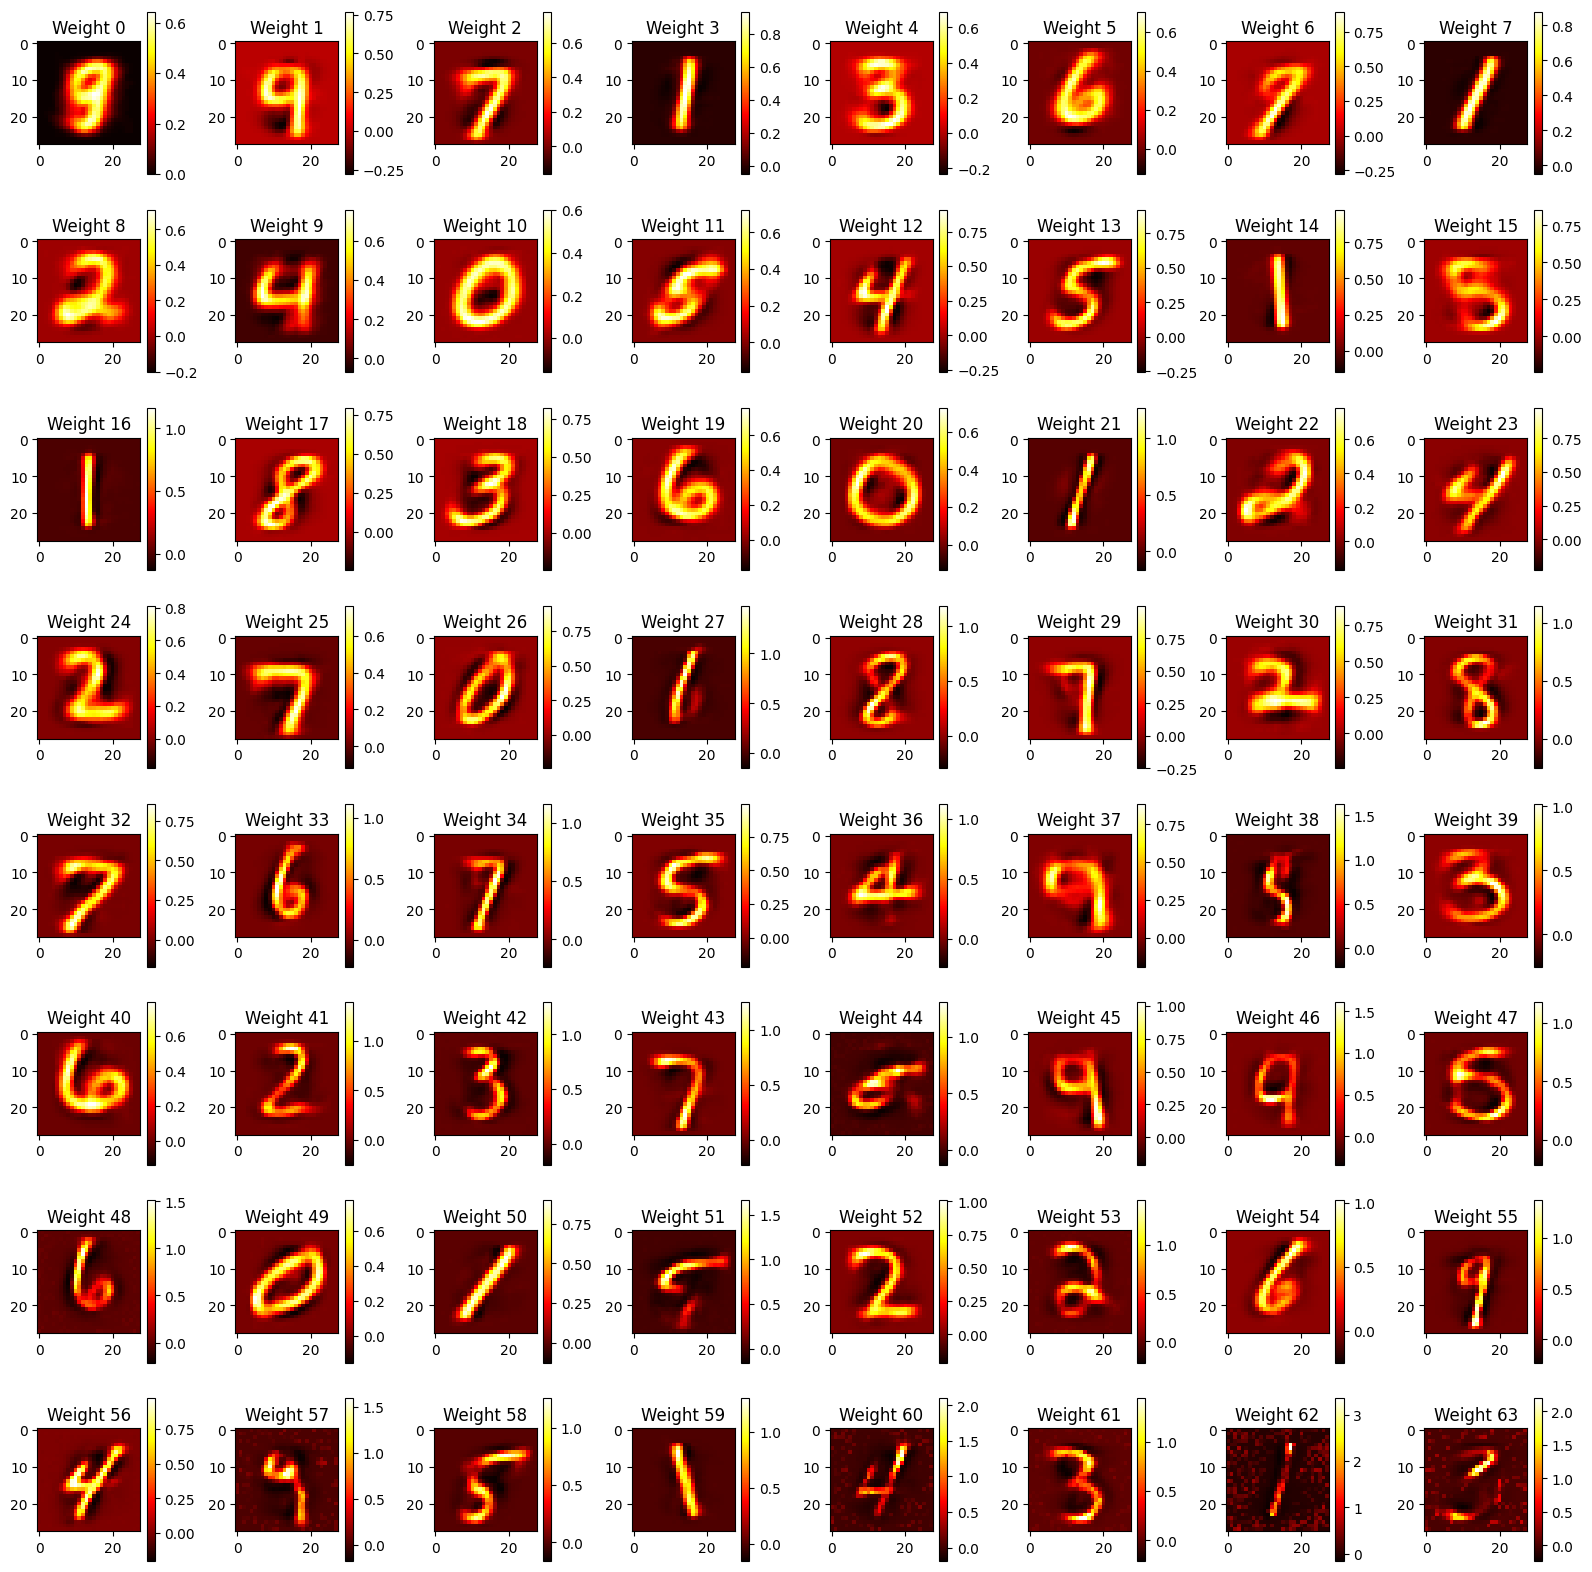

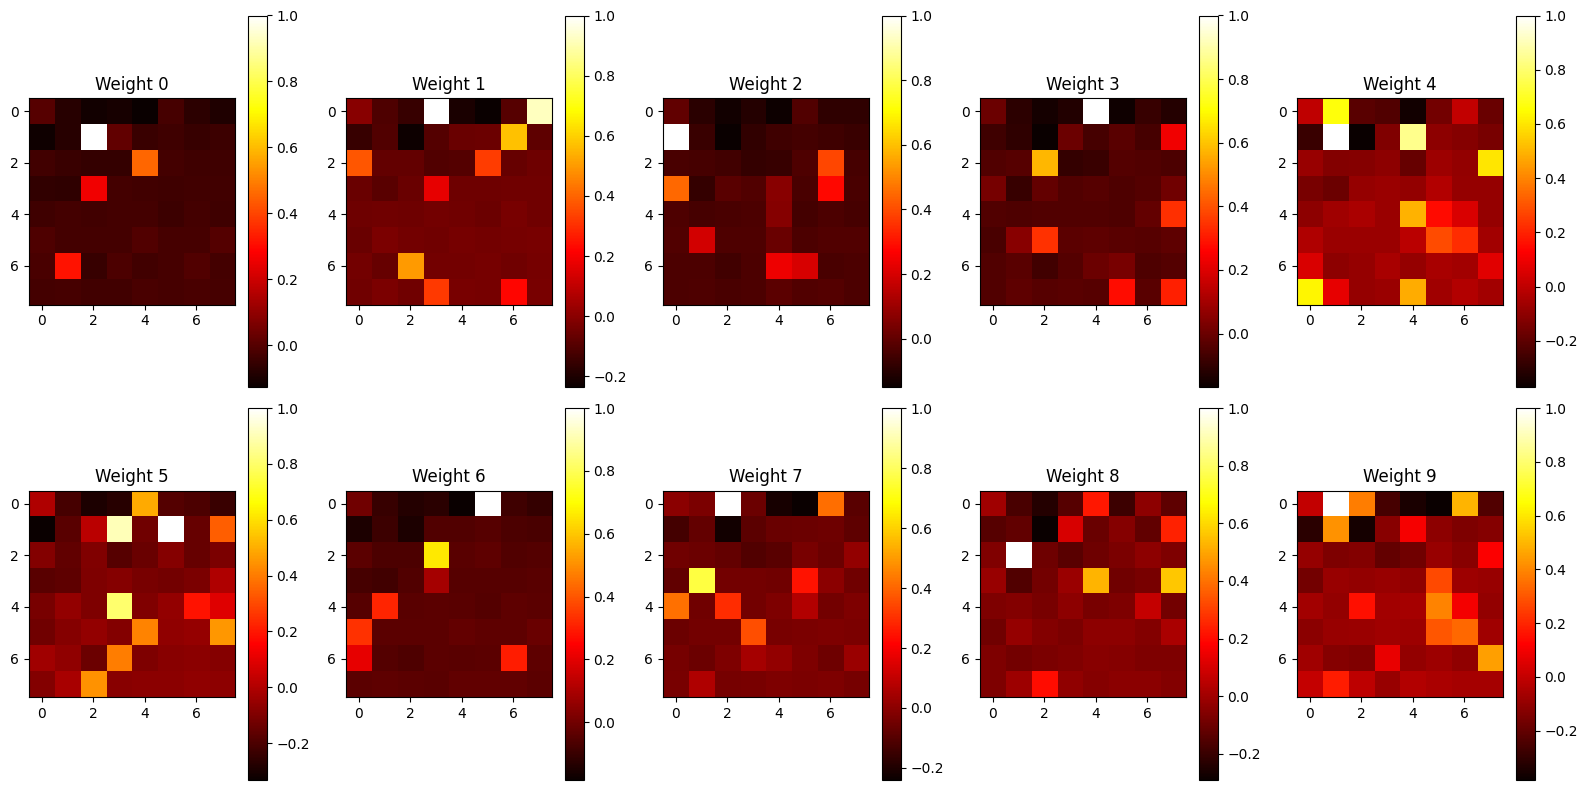

In [16]:
experiment.visualizeWeights()

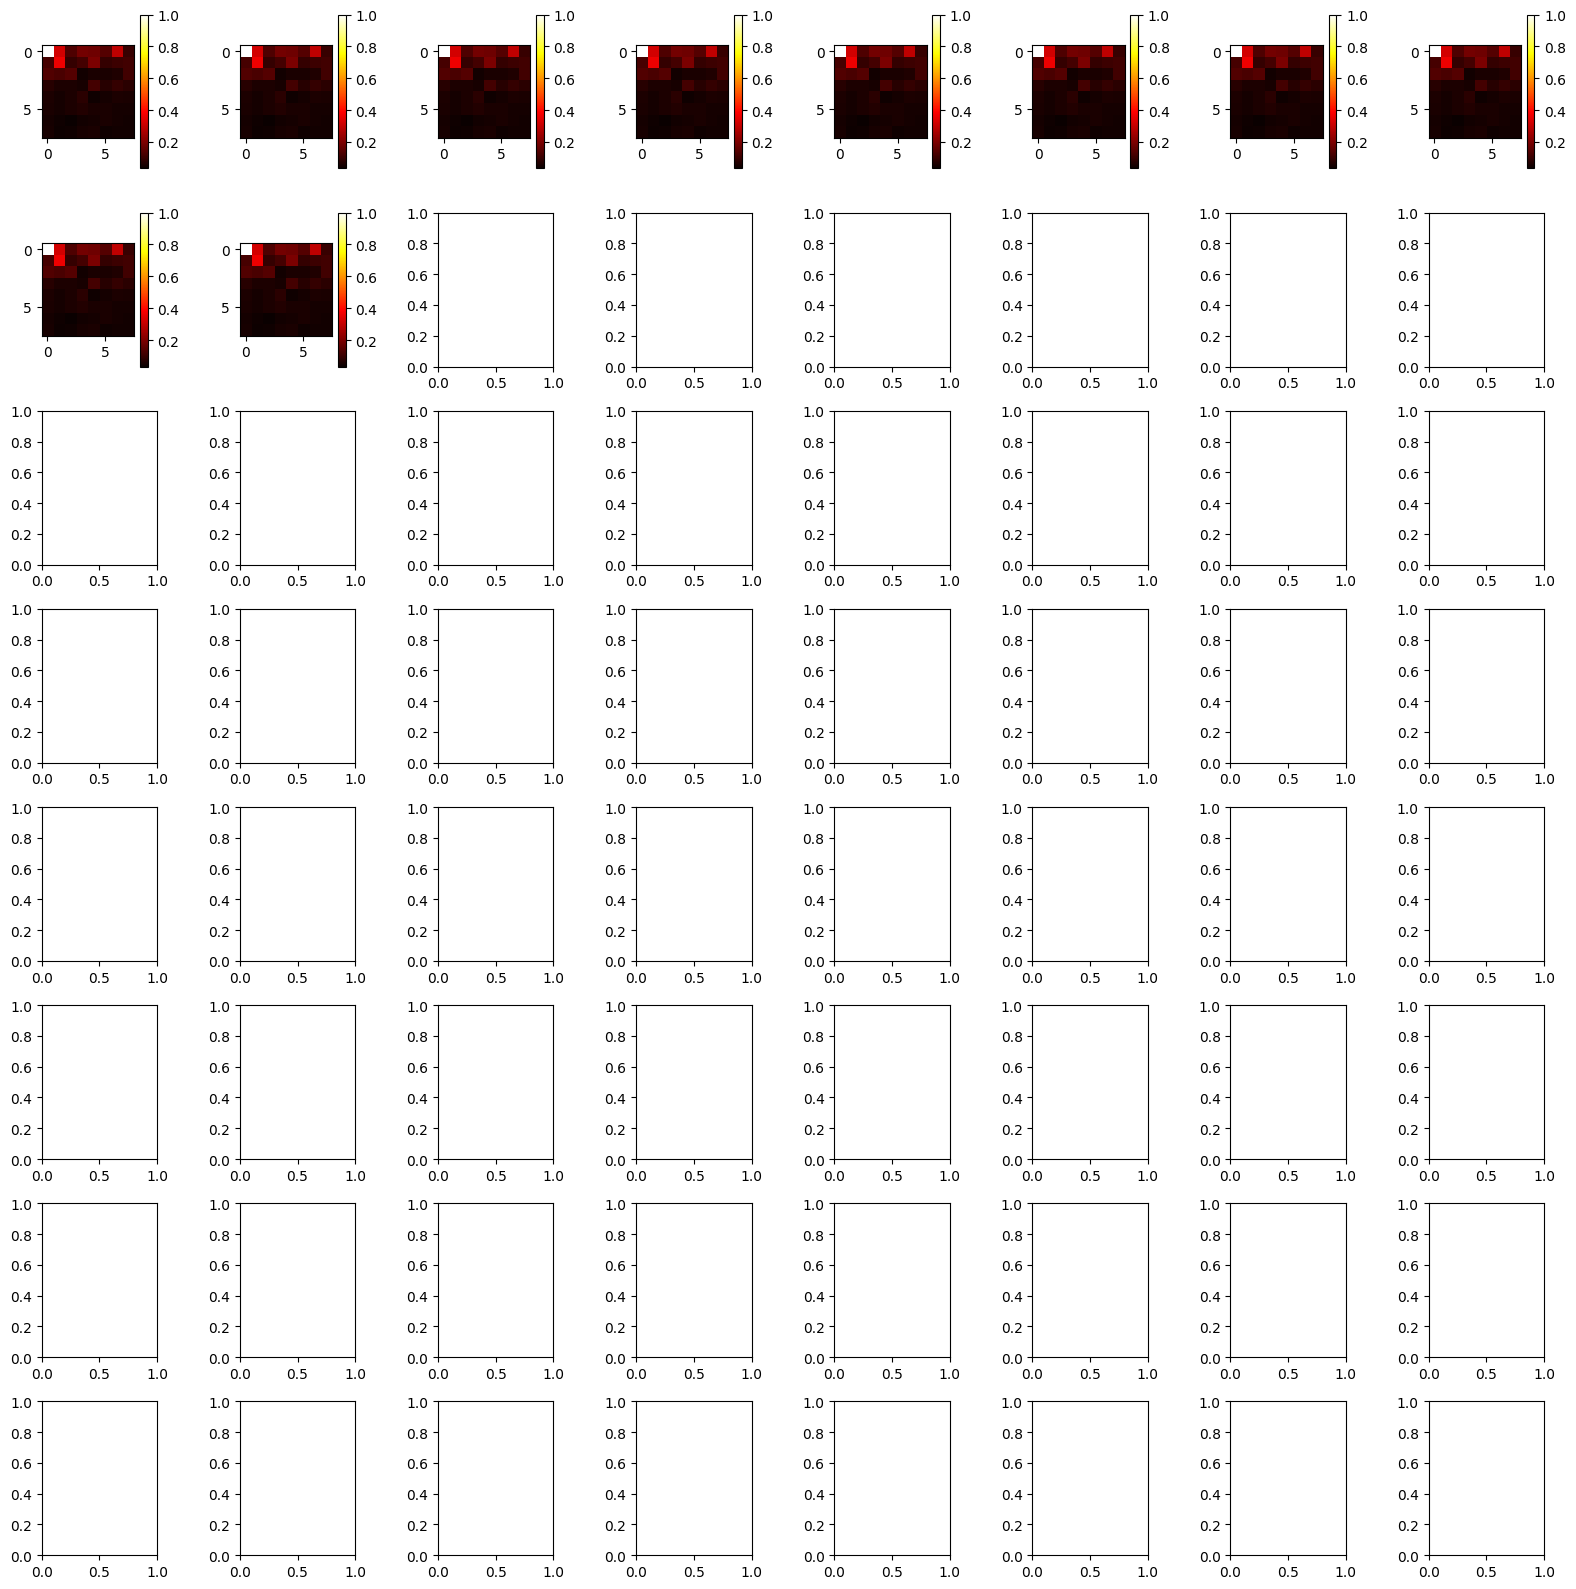

Parameter containing:
tensor([[1.0000, 0.3232, 0.1324, 0.1856, 0.1802, 0.1415, 0.2969, 0.0997, 0.1238,
         0.3623, 0.0948, 0.1187, 0.1963, 0.0968, 0.1082, 0.1138, 0.1394, 0.1263,
         0.1415, 0.0485, 0.0579, 0.0576, 0.0666, 0.1148, 0.0784, 0.0613, 0.0602,
         0.0553, 0.1172, 0.0769, 0.0954, 0.0807, 0.0623, 0.0500, 0.0605, 0.0793,
         0.0436, 0.0505, 0.0631, 0.0577, 0.0587, 0.0516, 0.0603, 0.0713, 0.0566,
         0.0584, 0.0506, 0.0507, 0.0516, 0.0434, 0.0337, 0.0465, 0.0509, 0.0600,
         0.0498, 0.0464, 0.0531, 0.0397, 0.0413, 0.0558, 0.0578, 0.0418, 0.0481,
         0.0451],
        [1.0000, 0.3232, 0.1324, 0.1856, 0.1802, 0.1415, 0.2969, 0.0997, 0.1238,
         0.3623, 0.0948, 0.1187, 0.1963, 0.0968, 0.1082, 0.1138, 0.1394, 0.1263,
         0.1415, 0.0485, 0.0579, 0.0576, 0.0666, 0.1148, 0.0784, 0.0613, 0.0602,
         0.0553, 0.1172, 0.0769, 0.0954, 0.0807, 0.0623, 0.0500, 0.0605, 0.0793,
         0.0436, 0.0505, 0.0631, 0.0577, 0.0587, 0.0516, 0.0603, 0.07

In [5]:
experiment.visualizeWeights(10, classifier=1)
print(experiment.model.classifier_layer.fc.weight)

In [4]:
experiment.test()

tensor(8)
6
tensor(8)
7
tensor(8)
8
tensor(6)
5
tensor(8)
0
tensor(8)
6
tensor(9)
3
tensor(6)
3
tensor(8)
1
tensor(7)
6
tensor(9)
0
tensor(6)
8
tensor(8)
4
tensor(9)
6
tensor(9)
7
tensor(8)
5
tensor(8)
7
tensor(6)
1
tensor(8)
9
tensor(8)
8
tensor(8)
4
tensor(9)
8
tensor(9)
8
tensor(8)
3
tensor(8)
9
tensor(9)
4
tensor(6)
2
tensor(8)
3
tensor(8)
5
tensor(8)
7
tensor(8)
7
tensor(9)
3
tensor(7)
9
tensor(9)
2
tensor(8)
4
tensor(6)
7
tensor(6)
8
tensor(7)
2
tensor(9)
2
tensor(4)
1
tensor(6)
1
tensor(8)
8
tensor(8)
9
tensor(6)
6
tensor(9)
0
tensor(9)
1
tensor(6)
8
tensor(6)
8
tensor(6)
5
tensor(9)
3
tensor(8)
8
tensor(7)
2
tensor(8)
8
tensor(9)
8
tensor(7)
0
tensor(6)
3
tensor(7)
0
tensor(9)
0
tensor(7)
0
tensor(7)
4
tensor(6)
8
tensor(9)
2
tensor(6)
5
tensor(9)
0
tensor(8)
3
tensor(9)
9
tensor(9)
3
tensor(9)
6
tensor(8)
5
tensor(9)
2
tensor(9)
0
tensor(9)
6
tensor(9)
2
tensor(9)
3
tensor(8)
3
tensor(7)
0
tensor(9)
2
tensor(6)
6
tensor(9)
8
tensor(6)
0
tensor(8)
3
tensor(8)
1
tensor(6)
0
tens

KeyboardInterrupt: 